In [1]:
import numpy as np
import squigglepy as sq
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from pprint import pprint
from datetime import datetime, timedelta


O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)


def run_model(model, index_date=O3_LAUNCH_DATE):
    samples = sq.sample(model, n=100_000, verbose=True)
    pprint(sq.get_percentiles(samples, digits=0))
    print('\n-\n')
    samples_ = sq.get_percentiles(samples_to_date(samples, index_date=index_date))
    samples_ = {k: v.strftime("%Y %b %d") for k, v in samples_.items()}
    pprint(samples_)
    return samples


def calculate_doubling_time(start_task_length, agi_task_length, doubling_time):
    """
    Start task_length (hours) => What is the current task task_length for AI on economically-relevant tasks (in hours)? Covers unceraginty about reliability needs.
    End task_length (hours) => What task task_length is needed on economically-rlevant tasks (in hours) to achieve AGI? Covers unceraginty in task task_length needed for AGI.
    Doubling time (days) => How many days for task task_length to double? Covers unceraginty in rate of exponential
    """
    doublings_needed = sq.dist_log(agi_task_length / start_task_length) / np.log(2)
    return doublings_needed * doubling_time


def samples_to_date(samples, index_date=O3_LAUNCH_DATE):
    date_converter = np.vectorize(lambda x: index_date + timedelta(days=int(np.ceil(x))))
    return date_converter(samples)


print('Fast model')
print(samples_to_date(calculate_doubling_time(start_task_length=7.57, agi_task_length=167, doubling_time=90) @ 1))
print('-')
print('Slow model')
print(samples_to_date(calculate_doubling_time(start_task_length=5/60/60, agi_task_length=4000, doubling_time=300) @ 1))
print('-')

Fast model
2026-05-23 00:00:00
-
Slow model
2042-12-01 00:00:00
-


In [2]:
def metr_model():
    days = calculate_doubling_time(start_task_length=1, agi_task_length=167, doubling_time=212) # Variables from METR paper
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add easurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

_ = run_model(metr_model, index_date=CLAUDE_3P7_LAUNCH_DATE) # Results should look similar to Figure 12

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12693.17it/s]


{1: 1099,
 5: 1252,
 10: 1341,
 20: 1459,
 30: 1550,
 40: 1633,
 50: 1714,
 60: 1799,
 70: 1895,
 80: 2015,
 90: 2193,
 95: 2351,
 99: 2684}

-

{1: '2028 Feb 29',
 5: '2028 Jul 30',
 10: '2028 Oct 28',
 20: '2029 Feb 22',
 30: '2029 May 24',
 40: '2029 Aug 16',
 50: '2029 Nov 04',
 60: '2030 Jan 28',
 70: '2030 May 05',
 80: '2030 Sep 01',
 90: '2031 Feb 27',
 95: '2031 Aug 04',
 99: '2032 Jul 02'}


In [3]:
def metr_model_with_o3():
    days = calculate_doubling_time(start_task_length=1.75, agi_task_length=167, doubling_time=118) # Use o3 task length, o3 launch date, and the 2024-2025 doubling time
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

_ = run_model(metr_model_with_o3, index_date=O3_LAUNCH_DATE)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:08<00:00, 12364.93it/s]


{1: 543,
 5: 620,
 10: 665,
 20: 724,
 30: 769,
 40: 810,
 50: 850,
 60: 893,
 70: 940,
 80: 999,
 90: 1088,
 95: 1165,
 99: 1328}

-

{1: '2026 Oct 12',
 5: '2026 Dec 28',
 10: '2027 Feb 11',
 20: '2027 Apr 11',
 30: '2027 May 26',
 40: '2027 Jul 06',
 50: '2027 Aug 15',
 60: '2027 Sep 27',
 70: '2027 Nov 13',
 80: '2028 Jan 11',
 90: '2028 Apr 09',
 95: '2028 Jun 24',
 99: '2028 Dec 05'}


In [4]:
print('## START task length (displayed in min) ##')
current_best = 1.75 # o3 task length at 50% reliability?

reliability_needed = sq.mixture([[0.3, 0.5], # What amount of reliability will we need? Probability distribution over hypotheses
                                 [0.4, 0.8],
                                 [0.2, 0.9],
                                 [0.1, 0.99]])

def reliability_count_to_penalty(reliability):
    r = np.asarray(reliability, dtype=float)
    reliability = np.array([0.50, 0.80, 0.90, 0.95, 0.99])
    penalty = np.array([1.0, 0.25, 0.25**2, 0.25**3, 0.25**4])
    matches = r[..., None] == reliability
    hit_any = matches.any(axis=-1)
    idx = matches.argmax(axis=-1)
    out = np.full_like(r, np.nan, dtype=float)
    out[hit_any] = penalty[idx[hit_any]]
    return out

task_type_penalty = sq.mixture([[0.2, 1],                         # 20% chance that METR's software tasks are sufficient for AGI
                                [0.4, 1 / sq.lognorm(5, 20)],     # 40% chance that true AGI tasks are 5-20x harder than METR's software tasks
                                [0.4, 1 / sq.lognorm(10, 1000)]]) # 40% chance that true AGI tasks are 10-1000x harder than METR's software tasks

# Start with current best, add reliability penalty
start_task_length = current_best * sq.dist_fn(reliability_needed, reliability_count_to_penalty)

# Add task type penalty
start_task_length *= task_type_penalty

# Add a minimum value of 30sec
start_task_length = sq.dist_max(30/60/60, start_task_length)

# Show samples in minutes (naturally in hours)
sq.get_percentiles((start_task_length * 60) @ 100_000, digits=1)

## START task length (displayed in min) ##


{1: 0.5,
 5: 0.5,
 10: 0.5,
 20: 0.5,
 30: 0.5,
 40: 0.8,
 50: 1.7,
 60: 2.9,
 70: 6.4,
 80: 10.8,
 90: 26.2,
 95: 105.0,
 99: 105.0}

In [5]:
print('## AGI task length (displayed in hrs) ##')
agi_task_length = sq.lognorm(40, 2000, credibility=80, lclip=40)
sq.get_percentiles(agi_task_length @ 100_000, digits=0)

## AGI task length (displayed in hrs) ##


{1: 40,
 5: 40,
 10: 40,
 20: 78,
 30: 127,
 40: 192,
 50: 283,
 60: 415,
 70: 628,
 80: 1022,
 90: 1974,
 95: 3428,
 99: 10080}

In [6]:
print('## DOUBLING TIME (displayed in days) ##')
doubling_time = sq.lognorm(90, 250, credibility=80, lclip=60)
sq.get_percentiles(doubling_time @ 100_000, digits=0)

## DOUBLING TIME (displayed in days) ##


{1: 60,
 5: 78,
 10: 90,
 20: 107,
 30: 122,
 40: 136,
 50: 150,
 60: 166,
 70: 185,
 80: 210,
 90: 250,
 95: 289,
 99: 379}

In [7]:
print('## SHIFT (displayed in days) ##')
shift = sq.norm(30, 30*5, credibility=80, lclip=0)
sq.get_percentiles(shift @ 100_000, digits=0)

## SHIFT (displayed in days) ##


{1: 0,
 5: 13,
 10: 30,
 20: 51,
 30: 65,
 40: 78,
 50: 90,
 60: 101,
 70: 114,
 80: 129,
 90: 150,
 95: 166,
 99: 198}

In [8]:
def adapted_metr_model():
    start_task_length_ = start_task_length * (2 ** (shift / doubling_time))
    days = calculate_doubling_time(start_task_length_, agi_task_length, doubling_time)
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add easurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

samples = run_model(adapted_metr_model)

100%|███████████████████████████████████████████████████████████████████████████| 100000/100000 [01:06<00:00, 1506.33it/s]


{1: 535,
 5: 796,
 10: 974,
 20: 1247,
 30: 1486,
 40: 1719,
 50: 1965,
 60: 2240,
 70: 2572,
 80: 3015,
 90: 3751,
 95: 4494,
 99: 6222}

-

{1: '2026 Oct 04',
 5: '2027 Jun 21',
 10: '2027 Dec 17',
 20: '2028 Sep 15',
 30: '2029 May 12',
 40: '2029 Dec 31',
 50: '2030 Sep 02',
 60: '2031 Jun 04',
 70: '2032 May 01',
 80: '2033 Jul 19',
 90: '2035 Jul 25',
 95: '2037 Aug 06',
 99: '2042 Apr 30'}


In [9]:
print('## DISTRIBUTION OF AGI ARRIVAL DATE ##')
# Convert datetime samples to years
agi_years = [s / 365 + 2025 for s in samples]
pctiles = sq.get_percentiles(agi_years, percentiles=[1, 2, 3, 4, 5, 10, 15, 20, 25, 35, 50, 60, 75, 80, 90, 95])
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1], 1))) if o[1] < 2100 else '>2100') 
    for o in pctiles.items()
])
print('')
print('')
print('## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##')
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1] - 2025, 1))) if o[1] < 2100 else '>75') + ' years from now' 
    for o in pctiles.items()
])
print('(Mean: {} years from now)'.format(int(round(np.mean([t - 2025 for t in agi_years])))))
print('')
print('')


print('## AGI ARRIVAL DATE BY BIN ##')

def bin_agi_yrs(low=None, hi=None):
    low = 2025 if low is None else low
    if hi is None:
        r = np.mean([y >= low for y in agi_years])
    else:
        r = np.mean([(y >= low) and (y <= hi) for y in agi_years])
    return round(r * 100, 1)


year_pairs = [[2025, 2026],
              [2026, 2027],
              [2027, 2028],
              [2028, 2029],
              [2029, 2030],
              [2030, 2032],
              [2032, 2035],
              [2035, 2040],
              [2040, 2050],
              [2050, 2060],
              [2060, 2070],
              [2070, 2080],
              [2080, 2090],
              [2090, 2100]]
for y in year_pairs:
    if y[0] == y[1] - 1:
        print('{}: {}%'.format(y[0], bin_agi_yrs(y[0], y[1])))
    else:
        print('{}-{}: {}%'.format(y[0], y[1]-1, bin_agi_yrs(y[0], y[1])))
print('>{}: {}%'.format(2100, bin_agi_yrs(low=2100)))
print('')
print('')

print('## AGI ARRIVAL DATE BY YEAR ##')
for y in list(range(2025, 2035)) + list(range(2035, 2100, 5)):
    print('By EOY {}: {}%'.format(y, bin_agi_yrs(hi=y+1)))
print('')

## DISTRIBUTION OF AGI ARRIVAL DATE ##
['1%: 2026.5',
 '2%: 2026.7',
 '3%: 2026.9',
 '4%: 2027.1',
 '5%: 2027.2',
 '10%: 2027.7',
 '15%: 2028.1',
 '20%: 2028.4',
 '25%: 2028.7',
 '35%: 2029.4',
 '50%: 2030.4',
 '60%: 2031.1',
 '75%: 2032.6',
 '80%: 2033.3',
 '90%: 2035.3',
 '95%: 2037.3']


## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##
['1%: 1.5 years from now',
 '2%: 1.7 years from now',
 '3%: 1.9 years from now',
 '4%: 2.1 years from now',
 '5%: 2.2 years from now',
 '10%: 2.7 years from now',
 '15%: 3.1 years from now',
 '20%: 3.4 years from now',
 '25%: 3.7 years from now',
 '35%: 4.4 years from now',
 '50%: 5.4 years from now',
 '60%: 6.1 years from now',
 '75%: 7.6 years from now',
 '80%: 8.3 years from now',
 '90%: 10.3 years from now',
 '95%: 12.3 years from now']
(Mean: 6 years from now)


## AGI ARRIVAL DATE BY BIN ##
2025: 0.2%
2026: 3.4%
2027: 10.5%
2028: 14.7%
2029: 15.5%
2030-2031: 25.2%
2032-2034: 19.5%
2035-2039: 8.9%
2040-2049: 1.9%
2050-2059: 0.1%
2060-2069: 0.0%
20

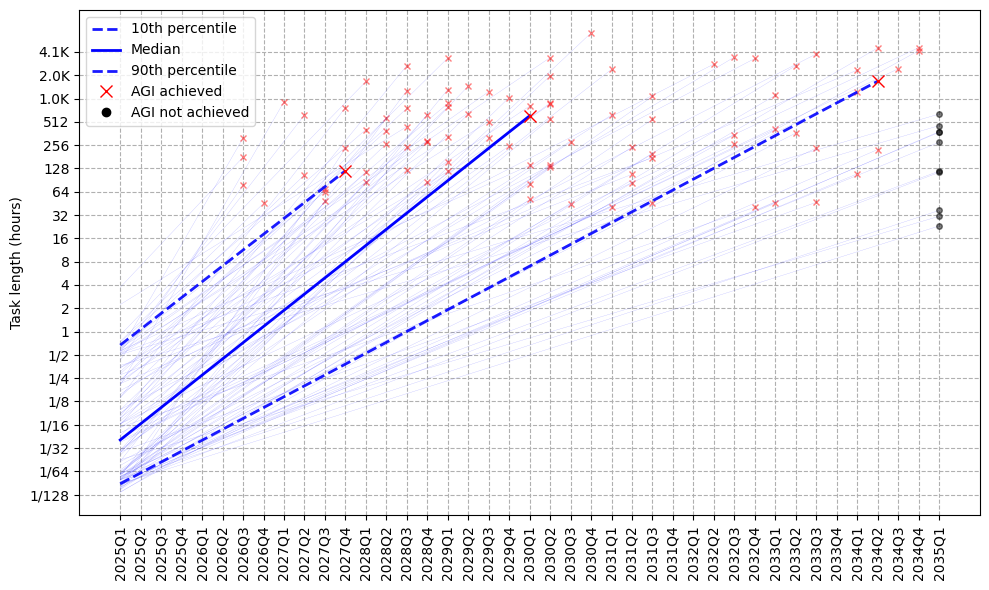

In [10]:
def billions_formatter(x, pos):
    if x >= 1e9:
        return f'{x/1e9:.1f}B'
    elif x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.1f}K'
    elif x <= 0.5:
        return f'1/{1/x:.0f}'
    else:
        return f'{x:.0f}'


def plot_exponential_growth(doubling_time_days, starting_hours, agi_task_length, shift, n_quarters=12, n_samples=1000, n_traces=100):
    """
    Plot exponential growth over quarters based on a doubling time.
    
    Parameters:
    doubling_time_days (sq.Distribution): The number of days it takes to double, given as a Squigglepy distribution
    starting_hours (sq.Distribution): The starting task length in hours, given as a Squigglepy distribution
    agi_task_length (sq.Distribution): The AGI task length in hours, given as a Squigglepy distribution
    shift (sq.Distribution): The number of days to shift earlier due to difference between internal development and launch date, given as a Squigglepy distribution
    n_quarters (int): Number of quarters to plot
    n_samples (int): Number of samples to plot
    n_traces (int): Number of individual traces to plot
    """
    days_per_quarter = 365 / 4
    quarters = np.arange(0, n_quarters + 1)
    days = quarters * days_per_quarter
    
    # Sample from distributions
    doubling_times = doubling_time_days @ n_samples
    shifts = shift @ n_samples
    starting_values = starting_hours @ n_samples
    end_values = agi_task_length @ n_samples

    # Adjust starting times for shift
    starting_values *= (2 ** (shifts / doubling_times))
    
    # Calculate growth rates from doubling times
    growth_rates = np.log(2) / np.array(doubling_times)
    
    # Calculate all trajectories
    trajectories = np.zeros((n_samples, len(quarters)))
    for i in range(n_samples):
        trajectories[i, :] = starting_values[i] * np.exp(growth_rates[i] * days)
    
    # Find termination points for each trajectory
    mask = trajectories > end_values.reshape(-1, 1)
    first_exceed = np.argmax(mask, axis=1)
    first_exceed[np.all(~mask, axis=1)] = len(quarters)  # Set to beyond the graph if never exceeds
    
    # Find the 10th, 50th, and 90th percentile termination dates
    sorted_indices_by_termination = np.argsort(first_exceed)
    p10_terminate_idx = sorted_indices_by_termination[int(0.1 * n_samples)]
    p50_terminate_idx = sorted_indices_by_termination[int(0.5 * n_samples)]
    p90_terminate_idx = sorted_indices_by_termination[int(0.9 * n_samples)]
    
    p10_terminate_quarter = first_exceed[p10_terminate_idx]
    p50_terminate_quarter = first_exceed[p50_terminate_idx]
    p90_terminate_quarter = first_exceed[p90_terminate_idx]
    
    # Cap at the maximum number of quarters
    p10_terminate_quarter = min(p10_terminate_quarter, len(quarters) - 1)
    p50_terminate_quarter = min(p50_terminate_quarter, len(quarters) - 1)
    p90_terminate_quarter = min(p90_terminate_quarter, len(quarters) - 1)
    
    # Now we'll get three distinct starting values that are ordered
    # from largest to smallest to avoid crossing lines
    start_values_percentiles = [90, 50, 10]  # Largest to smallest
    p10_start = np.percentile(starting_values, start_values_percentiles[0])
    p50_start = np.percentile(starting_values, start_values_percentiles[1])
    p90_start = np.percentile(starting_values, start_values_percentiles[2])
    
    # Use the actual end values from the representative trajectories
    p10_end = end_values[p10_terminate_idx]
    p50_end = end_values[p50_terminate_idx]
    p90_end = end_values[p90_terminate_idx]
    
    # Calculate growth rates that will connect start and end values at the right termination points
    if p10_terminate_quarter < len(quarters):
        days_to_termination = days[p10_terminate_quarter]
        growth_rate_p10 = np.log(p10_end / p10_start) / days_to_termination
    else:
        # No termination, use a reasonable growth rate
        growth_rate_p10 = np.percentile(growth_rates, 10)  # Slow growth
        
    if p50_terminate_quarter < len(quarters):
        days_to_termination = days[p50_terminate_quarter]
        growth_rate_p50 = np.log(p50_end / p50_start) / days_to_termination
    else:
        # No termination, use a reasonable growth rate
        growth_rate_p50 = np.percentile(growth_rates, 50)  # Medium growth
        
    if p90_terminate_quarter < len(quarters):
        days_to_termination = days[p90_terminate_quarter]
        growth_rate_p90 = np.log(p90_end / p90_start) / days_to_termination
    else:
        # No termination, use a reasonable growth rate
        growth_rate_p90 = np.percentile(growth_rates, 90)  # Fast growth
    
    # Calculate curves
    p10_curve = p10_start * np.exp(growth_rate_p10 * days)
    p50_curve = p50_start * np.exp(growth_rate_p50 * days)
    p90_curve = p90_start * np.exp(growth_rate_p90 * days)
    
    plt.figure(figsize=(10, 6))
    
    # Plot individual traces with X markers at end points
    if n_traces > 0:
        # Use a subset of trajectories for display if showing traces
        display_indices = np.random.choice(n_samples, min(n_traces, n_samples), replace=False)
        
        for i in display_indices:
            if first_exceed[i] >= len(quarters):
                # This curve never exceeds threshold
                plt.plot(quarters, trajectories[i], 'b-', linewidth=0.2, alpha=0.3)
                # Add black circle at the end
                plt.plot(quarters[-1], trajectories[i, -1], 'ko', markersize=4, alpha=0.5)
            else:
                # This curve exceeds threshold at some point
                end_idx = first_exceed[i]
                # Plot up to the end point
                plt.plot(quarters[:end_idx+1], trajectories[i, :end_idx+1], 'b-', linewidth=0.2, alpha=0.3)
                # Add an X marker at the end point
                plt.plot(quarters[end_idx], trajectories[i, end_idx], 'rx', markersize=4, alpha=0.5)
    
    # Plot the created percentile curves
    # 10th percentile
    if p10_terminate_quarter >= len(quarters):
        plt.plot(quarters, p10_curve, 'b--', linewidth=2, alpha=0.9, label='10th percentile')
        plt.plot(quarters[-1], p10_curve[-1], 'ko', markersize=6)
    else:
        plt.plot(quarters[:p10_terminate_quarter+1], p10_curve[:p10_terminate_quarter+1], 
                'b--', linewidth=2, alpha=0.9, label='10th percentile')
        plt.plot(quarters[p10_terminate_quarter], p10_curve[p10_terminate_quarter], 
                'rx', markersize=8, alpha=1)
    
    # 50th percentile
    if p50_terminate_quarter >= len(quarters):
        plt.plot(quarters, p50_curve, 'b-', linewidth=2, label='Median')
        plt.plot(quarters[-1], p50_curve[-1], 'ko', markersize=6)
    else:
        plt.plot(quarters[:p50_terminate_quarter+1], p50_curve[:p50_terminate_quarter+1], 
                'b-', linewidth=2, label='Median')
        plt.plot(quarters[p50_terminate_quarter], p50_curve[p50_terminate_quarter], 
                'rx', markersize=8, alpha=1)
    
    # 90th percentile
    if p90_terminate_quarter >= len(quarters):
        plt.plot(quarters, p90_curve, 'b--', linewidth=2, alpha=0.9, label='90th percentile')
        plt.plot(quarters[-1], p90_curve[-1], 'ko', markersize=6)
    else:
        plt.plot(quarters[:p90_terminate_quarter+1], p90_curve[:p90_terminate_quarter+1], 
                'b--', linewidth=2, alpha=0.9, label='90th percentile')
        plt.plot(quarters[p90_terminate_quarter], p90_curve[p90_terminate_quarter], 
                'rx', markersize=8, alpha=1)
    
    # Add marker explanations to legend
    # Create empty plots with the markers for the legend
    plt.plot([], [], 'rx', markersize=8, label='AGI achieved')
    plt.plot([], [], 'ko', markersize=6, label='AGI not achieved')
    
    plt.grid(True, linestyle='--', alpha=1)
    plt.yscale('log', base=2)  
    quarter_labels = [f"{2025+q//4}Q{q%4+1}" for q in quarters]
    plt.xticks(quarters, quarter_labels, rotation=90)
    plt.yticks([2**i for i in range(-7, 13)])
    plt.ylabel("Task length (hours)")
    plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))
    plt.legend()
    plt.tight_layout()
    plt.show()
    return None
    
plot_exponential_growth(doubling_time, start_task_length, agi_task_length, shift, n_quarters=40, n_samples=10_000, n_traces=100)